In [1]:
!pip install "sagemaker>=2.69.0" "transformers==4.12.3" --upgrade

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.


In [ ]:
!pip install torch==1.6.0 --upgrade

In [2]:
import torch
print(torch.__version__)

1.6.0


In [3]:
#From https://huggingface.co/transformers/model_doc/clip.html
from PIL import Image
import requests

from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

inputs = processor(text=["a photo of a cat", "a photo of a dog"], images=image, return_tensors="pt", padding=True)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities

Downloading:   0%|          | 0.00/316 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/842k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/512k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/389 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/568 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.42M [00:00<?, ?B/s]

ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


In [6]:
print("Label probs:", probs)

Label probs: tensor([[0.9949, 0.0051]], grad_fn=<SoftmaxBackward>)


# Zero-Shot Prediction
From https://github.com/openai/CLIP

The code below performs zero-shot prediction using CLIP, as shown in Appendix B in the paper. 

This example takes an image from the CIFAR-100 dataset, and predicts the most likely labels among the 100 textual labels from the dataset.

In [11]:
from torchvision.datasets import CIFAR100
from PIL import Image
import requests
import os

from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


In [12]:
# Download the dataset
cifar100 = CIFAR100(root=os.path.expanduser("~/.cache"), download=True, train=False)

0it [00:00, ?it/s]

Extracting /home/ec2-user/.cache/cifar-100-python.tar.gz to /home/ec2-user/.cache


In [77]:
# Prepare the inputs
image, class_id = cifar100[3635]

#image_input = preprocess(image).unsqueeze(0).to(device)
#text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in cifar100.classes]).to(device)


In [78]:
#inputs = processor(text=["a photo of a cat", "a photo of a dog"], images=image, return_tensors="pt", padding=True)
text=[]
for c in cifar100.classes:
    #print(f"a photo of a {c}") 
    text.append(f"a photo of a {c}")
inputs = processor(text=text, images=image, return_tensors="pt", padding=True)

In [79]:
outputs = model(**inputs)

In [80]:
logits_per_image = outputs.logits_per_image # this is the image-text similarity score

In [81]:
probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities

In [82]:
print(probs.size())

torch.Size([1, 100])


In [83]:
for i, x in enumerate(cifar100.classes):
    if probs[0][i] > 0.1:
        print(f"{cifar100.classes[i]:>16s}: {100 * probs[0][i]:.2f}%")

      maple_tree: 15.90%
        oak_tree: 40.24%
       pine_tree: 14.13%
     willow_tree: 25.83%


The class id:47 name:maple_tree


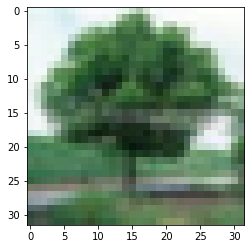

In [84]:
import matplotlib.pyplot as plt
print("The class id:{} name:{}".format(class_id, cifar100.classes[class_id]))
plt.imshow(image)

# Joint Image and text Embeddings
from https://marcelcastrobr.github.io/notebooks/2021/11/15/Image_Search.html

In [86]:
!pip install sentence-transformers

     |████████████████████████████████| 78 kB 9.9 MB/s  eta 0:00:01
     |████████████████████████████████| 1.2 MB 50.2 MB/s eta 0:00:01
  Created wheel for sentence-transformers: filename=sentence_transformers-2.1.0-py3-none-any.whl size=121580 sha256=8fe07332369512a623fd5bc35a715530379ad96dad5c4ed77cf7bfc2cd7c3bc3
  Stored in directory: /home/ec2-user/.cache/pip/wheels/4e/6f/20/06e0c1e209742a37ce7a5a9aa4e420a3abd5081c65b4b34d0a
Successfully built sentence-transformers
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.


In [89]:
import sentence_transformers
from sentence_transformers import SentenceTransformer, util
from PIL import Image
import glob
import torch
import pickle
import zipfile
from IPython.display import display
from IPython.display import Image as IPImage
import os
from tqdm.autonotebook import tqdm
torch.set_num_threads(4)

#First, we load the respective CLIP model
model = SentenceTransformer('clip-ViT-B-32')

ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


In [90]:
img_folder = 'photos/'
if not os.path.exists(img_folder) or len(os.listdir(img_folder)) == 0:
    os.makedirs(img_folder, exist_ok=True)
    
    photo_filename = 'unsplash-25k-photos.zip'
    if not os.path.exists(photo_filename):   #Download dataset if does not exist
        util.http_get('http://sbert.net/datasets/'+photo_filename, photo_filename)
        
    #Extract all images
    with zipfile.ZipFile(photo_filename, 'r') as zf:
        for member in tqdm(zf.infolist(), desc='Extracting'):
            zf.extract(member, img_folder)

In [91]:
# To speed things up, we destribute pre-computed embeddings
# Otherwise you can also encode the images yourself.
# To encode an image, you can use the following code:
# from PIL import Image
# img_emb = model.encode(Image.open(filepath))

use_precomputed_embeddings = True

if use_precomputed_embeddings: 
    emb_filename = 'unsplash-25k-photos-embeddings.pkl'
    if not os.path.exists(emb_filename):   #Download dataset if does not exist
        util.http_get('http://sbert.net/datasets/'+emb_filename, emb_filename)
        
    with open(emb_filename, 'rb') as fIn:
        img_names, img_emb = pickle.load(fIn)  
    print("Images:", len(img_names))
else:
    img_names = list(glob.glob('unsplash/photos/*.jpg'))
    print("Images:", len(img_names))
    img_emb = model.encode([Image.open(filepath) for filepath in img_names], batch_size=128, convert_to_tensor=True, show_progress_bar=True)

  0%|          | 0.00/51.8M [00:00<?, ?B/s]

Images: 24996


In [92]:
def search(query, k=3):
    # First, we encode the query (which can either be an image or a text string)
    query_emb = model.encode([query], convert_to_tensor=True, show_progress_bar=False)
    
    # Then, we use the util.semantic_search function, which computes the cosine-similarity
    # between the query embedding and all image embeddings.
    # It then returns the top_k highest ranked images, which we output
    hits = util.semantic_search(query_emb, img_emb, top_k=k)[0]
    
    print("Query:")
    display(query)
    for hit in hits:
        print(img_names[hit['corpus_id']])
        display(IPImage(os.path.join(img_folder, img_names[hit['corpus_id']]), width=200))


Query:


'Two cats playing on the street'

4mA9_5vbZ_s.jpg


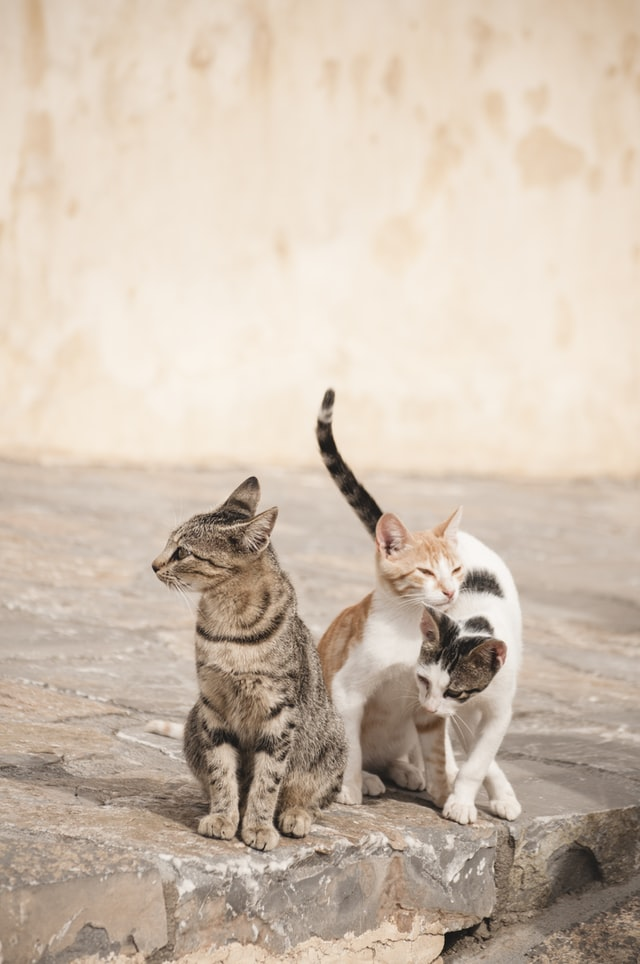

w6tMRf7kGLA.jpg


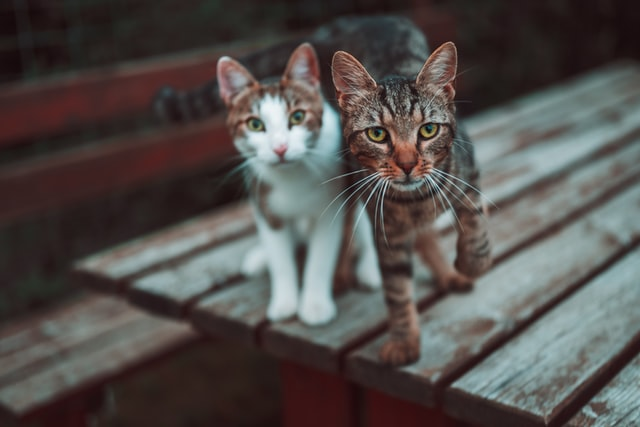

n4pNuXxyIr4.jpg


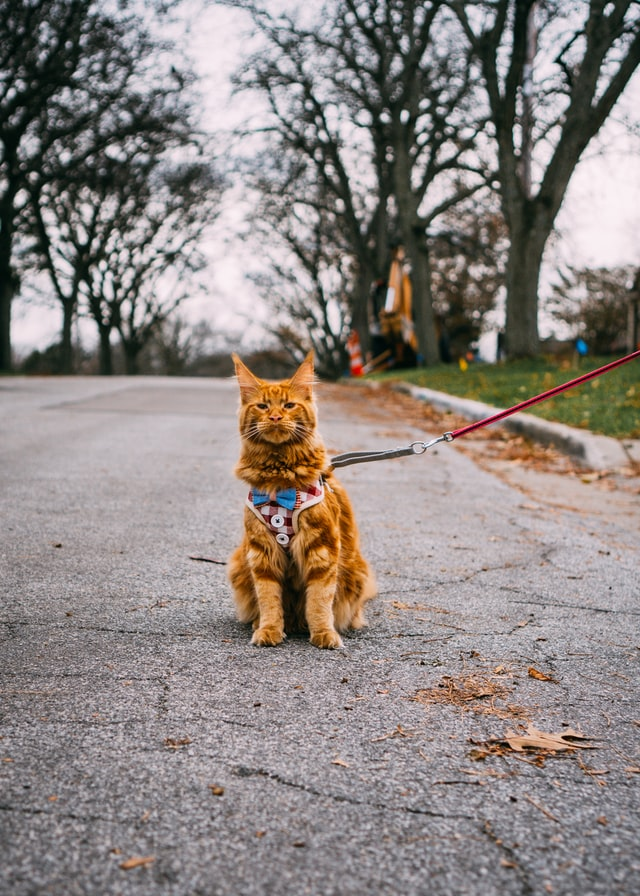

In [93]:
search("Two cats playing on the street")

## Image-to-Image Search

Query:


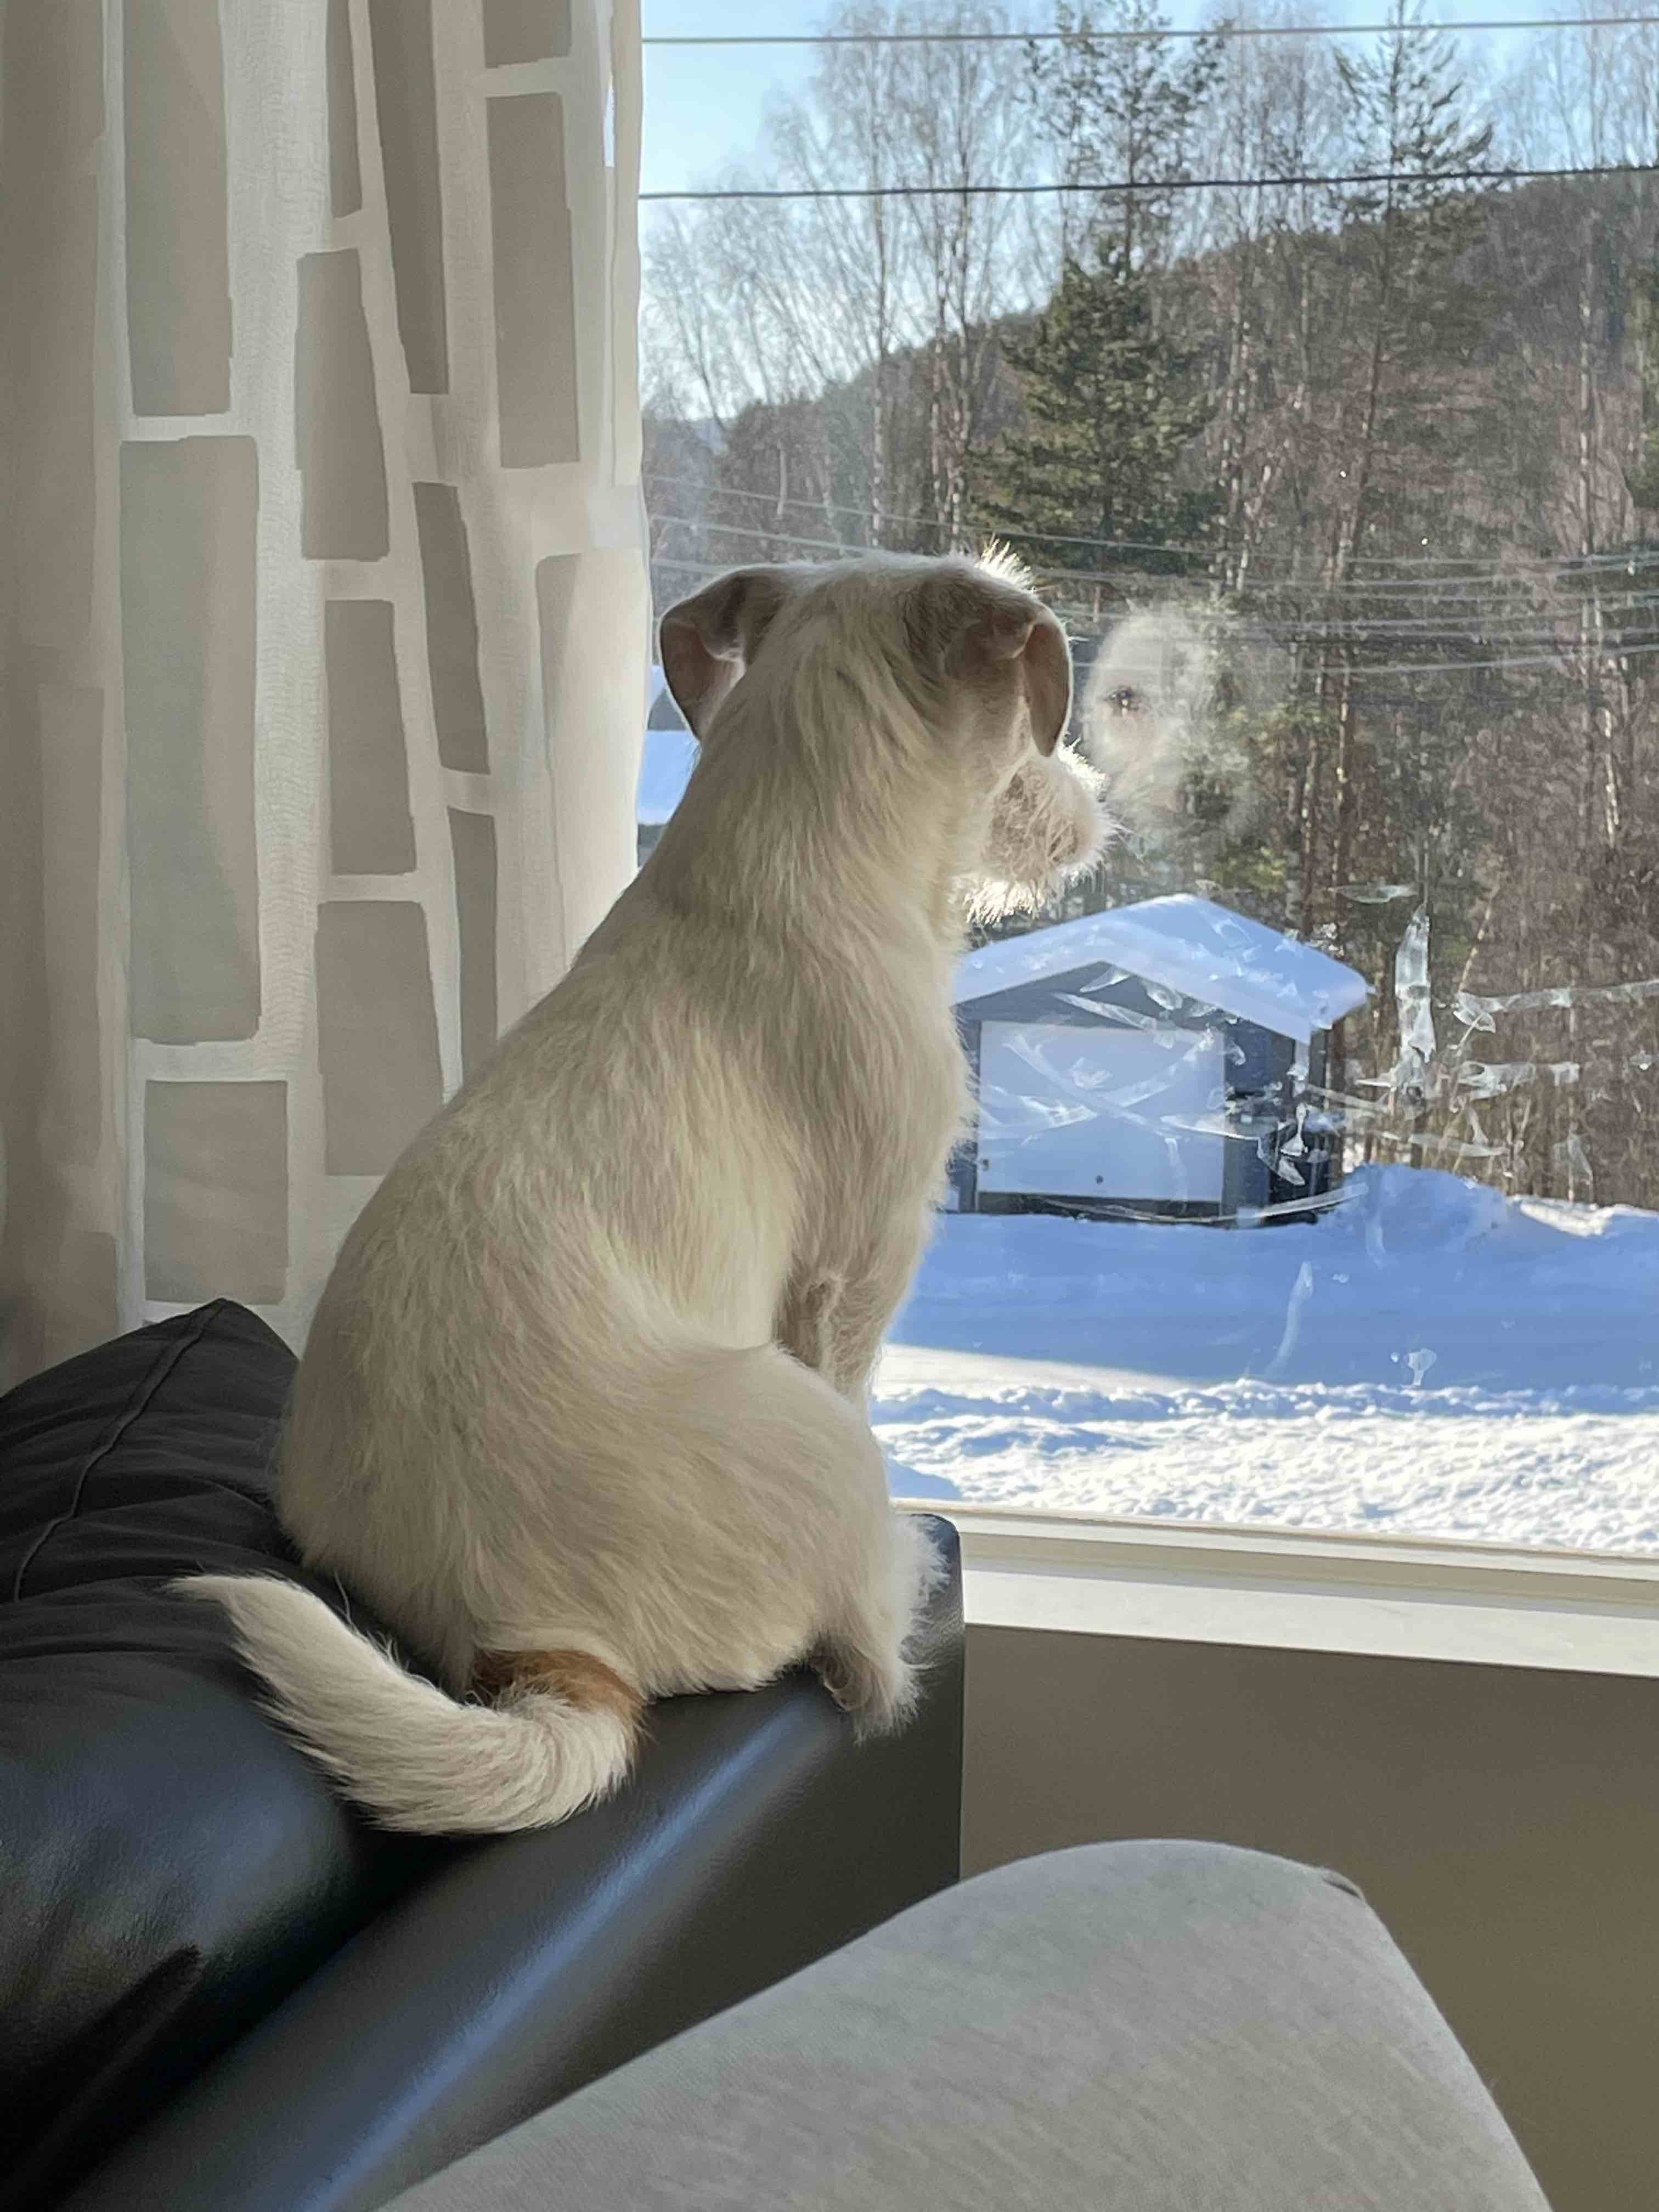

mgOXIPnyIxg.jpg


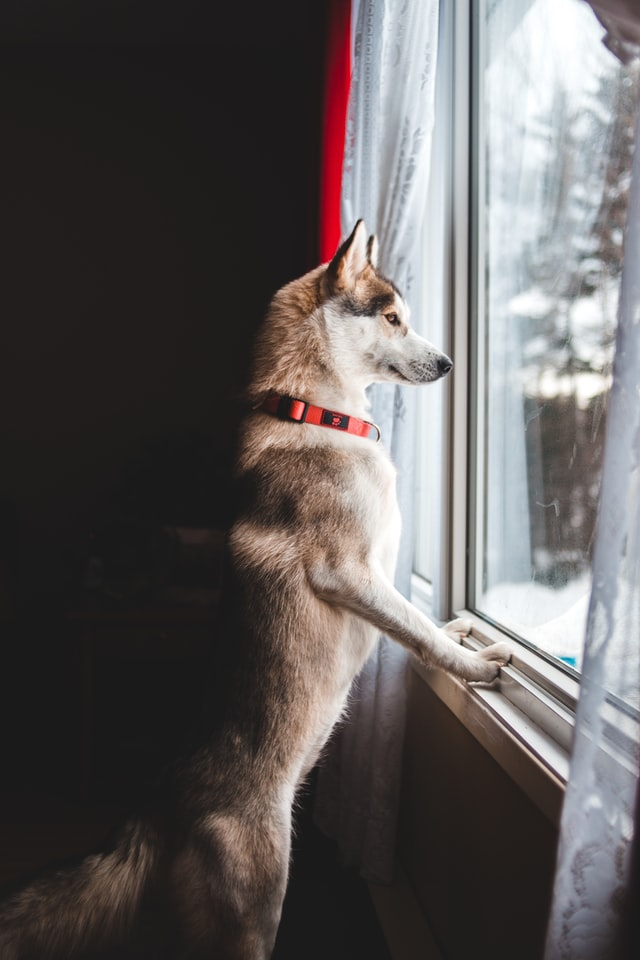

L8PkoOGLMSk.jpg


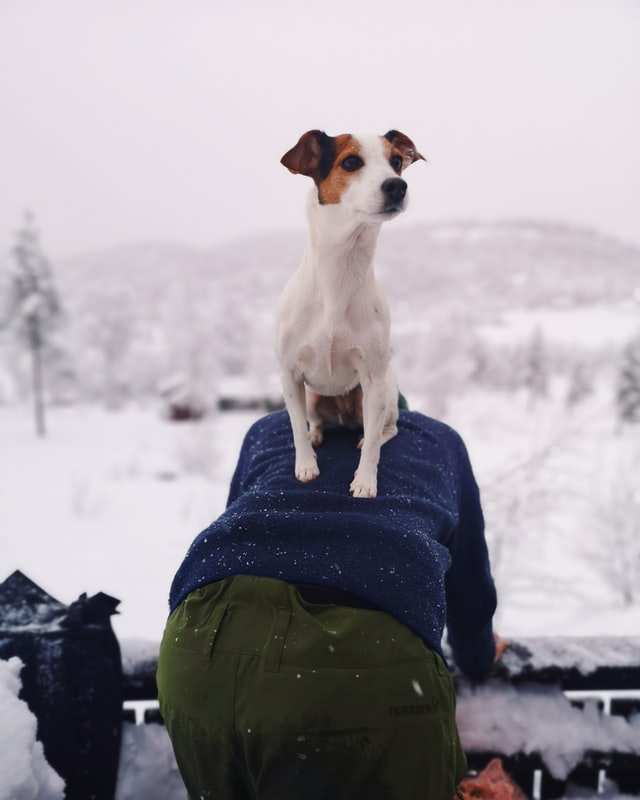

0T3R-QVgXUg.jpg


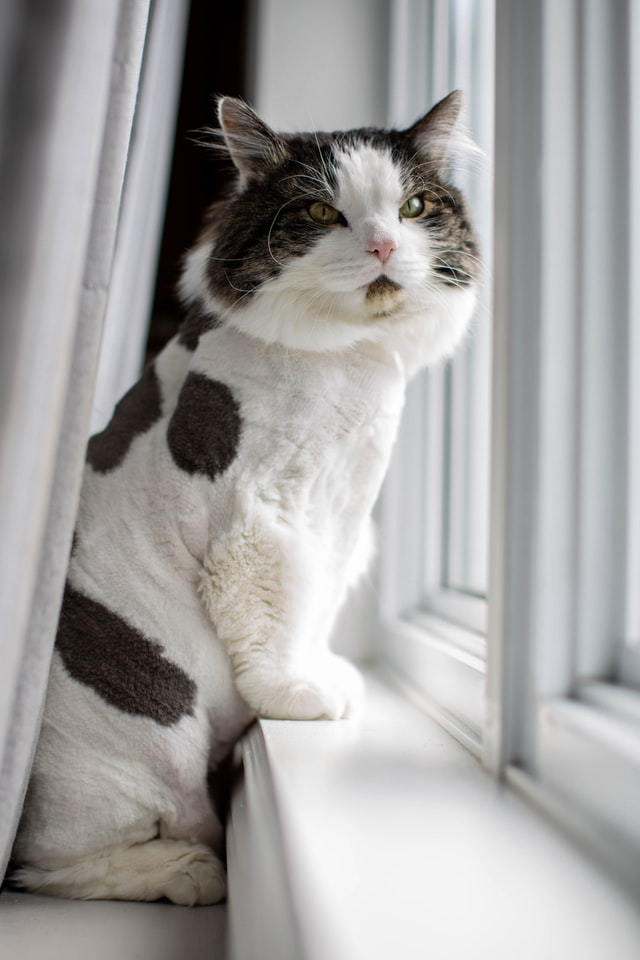

JqwRXYpSMDY.jpg


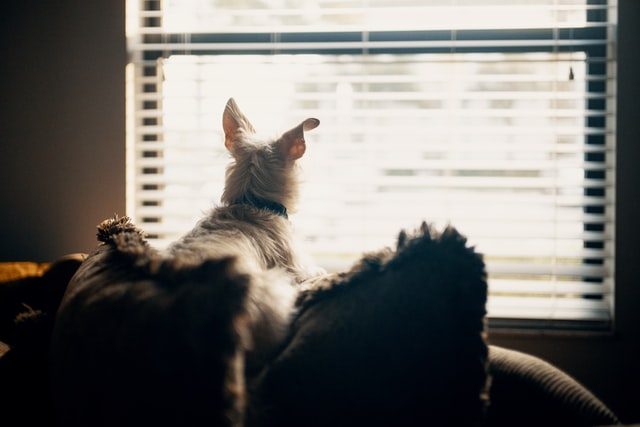

gcE6vwqOBjY.jpg


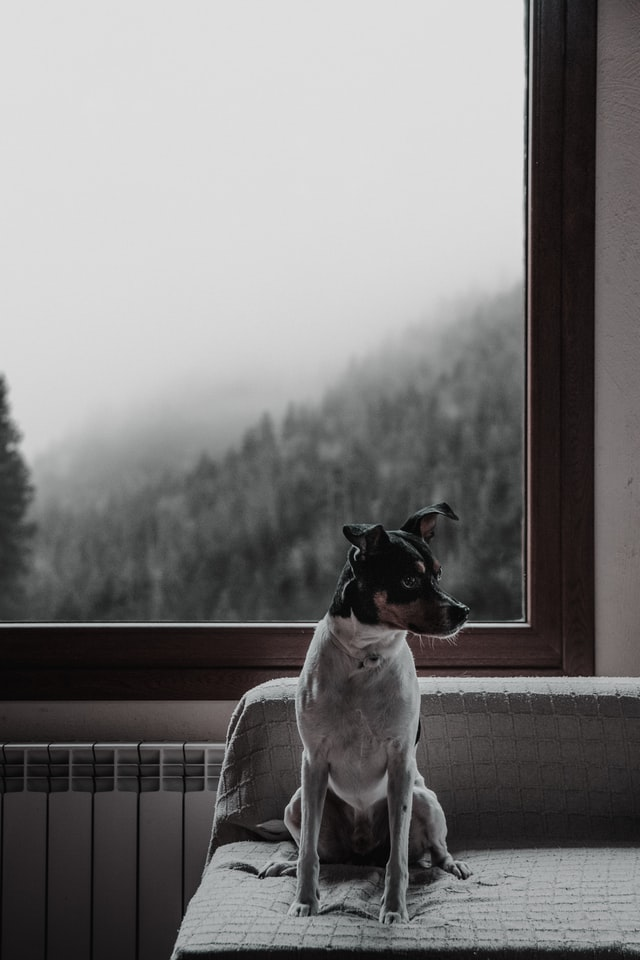

In [96]:
#Pass the image you would like to search
img_test_folder = 'test/'
search(Image.open(os.path.join(img_test_folder, 'branca.jpg')), k=5)